### Mean-Variance Potfolio Optimization with Elastic Net Penalty

Utilizes Pylops: python library of linear operators for inverse problems

In [2]:
import pylops 
import numpy as np
import pandas as pd
import scipy.optimize
import matplotlib.pyplot as plt

In [290]:
equity_data=pd.read_csv('equity_data_2021.csv')
equity_data.index=equity_data['Date']
equity_data=equity_data.drop(columns=['Date'])

returns=equity_data/equity_data.shift(1)
returns=returns.fillna(0)
returns

,MMM,AOS,ABT,ABBV,ABMD,ACN,ATVI,ADM,ADBE,ADP,...,WTW,GWW,WYNN,XEL,XYL,YUM,ZBRA,ZBH,ZION,ZTS
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2018-01-03,0.999958,1.006013,1.002211,1.015649,1.017300,1.004615,1.015550,0.992267,1.018796,1.010863,...,1.018709,0.993721,0.989166,0.993307,1.012193,0.999142,1.019863,1.006932,0.998817,1.004598
2018-01-04,1.013071,1.004685,0.998303,0.994297,1.017516,1.011841,0.990048,1.016843,1.012042,1.009552,...,1.010151,1.007813,1.005415,0.992209,1.006676,1.010180,1.019760,0.998559,1.004147,1.005964
2018-01-05,1.007792,1.012864,1.002890,1.017408,1.015408,1.008249,1.026446,0.993325,1.011571,0.999409,...,1.006413,1.009277,1.006671,0.992997,0.998126,1.005828,1.015576,1.009941,1.000393,1.011444
2018-01-08,0.996758,1.004763,0.997118,0.983978,1.027086,1.007991,1.003917,0.997760,0.998381,0.996957,...,0.994613,1.000000,0.986686,1.007480,1.003611,1.001690,1.009951,1.001905,0.995086,1.011996
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-27,1.009887,1.023318,1.016528,1.009918,1.015956,1.029803,1.004450,1.009627,1.014150,1.017727,...,1.010995,1.026123,0.985374,1.003153,1.006723,1.019728,1.041071,1.006457,1.010423,1.016494
2021-12-28,1.005320,1.009917,0.993002,0.999851,0.998910,0.999856,1.018640,1.013017,0.985598,0.999107,...,0.998578,1.009145,0.987212,1.011973,1.010398,0.999783,0.985140,1.003130,1.001587,0.990832
2021-12-29,1.004335,1.003156,1.005126,1.007218,1.012310,1.000361,1.007350,1.001195,0.999877,1.007884,...,0.998785,1.008678,0.982882,1.005028,0.998661,1.004928,1.006362,1.000156,1.005387,1.011382


### Computation of Naive mean and covariance estimation from sample

In [305]:
returns_mean=returns.mean()
returns_cov=np.cov(returns.T)

### Regularized Covariance and Mean Estimators

### Application of Sparse Solver Split Bregman Operator



In [312]:
def qp(cov,mean,w,d,b,beta,lambda1,tol,maxiter):
    """ Inner optimization problem using unconstrained optimization 
    """
    
    x0=w # initial guess is previous result
    def objective_val(w,cov,mean,d,b,beta,lambda1):
        """ MPT objective
        """
        
        obj=np.dot(np.dot(w,cov),w)-np.dot(w,mean)
        
        l2_pen=np.sum((d-beta*w-b)**2)

        return obj+lambda1*l2_pen/2

    res=scipy.optimize.minimize(objective_val,x0=w,args=(returns_cov,returns_mean,d,b,beta,lambda1),method='CG',options={'maxiter':100},tol=1e-5)
    
    w=res.x
    
    return w

def shrinkage(w,d,b,lambda1,beta):
    """ Shrinkage operator; second optimization routine
    """
    
    x=beta*w+b
    obj=np.fmax([np.abs(x)-(1/lambda1)],[np.zeros(len(w))])  # elementwise max
    signed_obj=np.sign(x)*obj

    return signed_obj[0]

def split_bregman(cov,mean,lambda1,beta=None,tol=1e-10,maxiter=100):
    """ Split Bregman Optimization Routine
    """

    error=1
    n=len(mean)
    if beta is None:
        beta=np.ones(n)
    
    b=np.zeros(n)
    w=np.zeros(n)
    d=np.zeros(n)
    
    
    lambda1=100
    
    i=0
    while error>tol:
        if i>maxiter:
            print("MaxIter Achieved")
            break
            
        
        if i%5==0 and i>0:
            print(f"{i}-th iteration with error of {error}")
        
        w_old=w
        w=qp(cov,mean,w_old,d,b,beta,lambda1,tol,maxiter)
        error=np.sum((w-w_old)**2)
        
        d=shrinkage(w,d,b,lambda1,beta)
        b=b+w-d       
        i+=1
    
    unit_w=w/np.linalg.norm(w,ord=1)
    print(f"Successfully terminated in {i} iterations of error {error}")
    return np.round(unit_w,4)



In [332]:
lambda1=1
w=split_bregman(returns_mean,returns_cov,lambda1=lambda1,tol=1e-12,maxiter=250)

5-th iteration with error of 6.941566842028009e-09
10-th iteration with error of 6.856296281634154e-09
15-th iteration with error of 6.773307372390217e-09
20-th iteration with error of 6.692537020864372e-09
25-th iteration with error of 6.614859955788553e-09
30-th iteration with error of 6.538356286070378e-09
35-th iteration with error of 6.464386982529332e-09
40-th iteration with error of 6.3924170070551235e-09
45-th iteration with error of 6.322270387953468e-09
50-th iteration with error of 6.254037837546642e-09
55-th iteration with error of 6.187098815129679e-09
60-th iteration with error of 6.123133321923604e-09
65-th iteration with error of 6.060023082682208e-09
70-th iteration with error of 5.998386052088087e-09
75-th iteration with error of 5.938314521583918e-09
80-th iteration with error of 5.8794710335325484e-09
85-th iteration with error of 5.822560552918407e-09
90-th iteration with error of 5.7668825793754015e-09
95-th iteration with error of 5.713028315942843e-09
100-th ite

### Numerical Results

Text(0.5, 0, '93 Nonzero components')

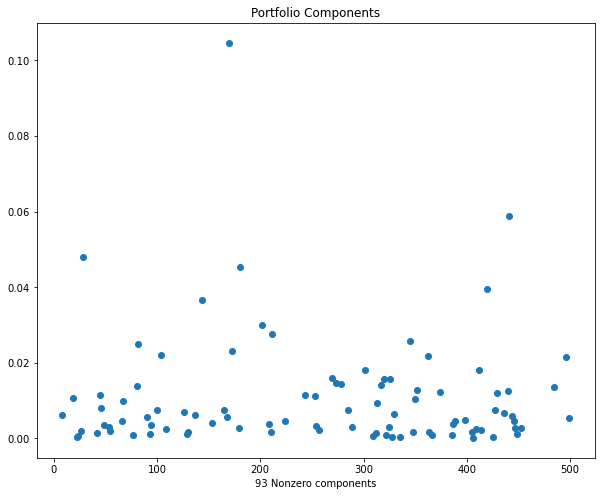

In [333]:
nonzero_w=np.where(w>0)[0]

fig,ax=plt.subplots(figsize=(10,8))
plt.title("Portfolio Components")
plt.scatter(nonzero_w,w[nonzero_w])
plt.xlabel(f"{len(nonzero_w)} Nonzero components")